In [1]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# outlier 處理

## 沒有處理 outlier

In [2]:
df = pd.read_csv('Final_2018-2022_data_file.csv')
dropping_columns = ['CropCode', 'CropName', 'MarketCode', 'MarketName', 'Upper_Price', 'Middle_Price', 'Lower_Price','day_of_year_y', 'month', 'year'
                    , 'day', 'day_of_year_x']
df = pd.DataFrame(data= df.drop(dropping_columns, axis= 1))

df.head()

,TransDate,Avg_Price,Trans_Quantity,測站氣壓(hPa),海平面氣壓(hPa),測站最高氣壓(hPa),測站最低氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),...,能見度(km),A型蒸發量(mm),總雲量(0~10),地溫0cm,地溫5cm,地溫10cm,地溫20cm,地溫30cm,地溫50cm,地溫100cm
0,107.01.02,15.0,1760.0,1020.5,1021.5,1022.9,1018.2,18.3,21.2,16.1,...,9.2,-0.6,10.0,18.0,18.1,18.3,18.5,18.3,19.5,20.5
1,107.01.03,15.0,1850.0,1019.3,1020.2,1021.1,1017.2,19.9,23.9,16.6,...,19.2,-1.4,8.8,19.1,19.5,19.6,19.0,19.1,19.5,20.5
2,107.01.04,15.0,1760.0,1015.8,1016.7,1018.8,1012.7,21.0,25.3,18.1,...,13.8,-1.7,9.0,20.7,20.6,20.3,19.9,19.6,20.0,20.5
3,107.01.05,15.0,1850.0,1016.4,1017.3,1019.3,1013.1,18.6,20.9,16.2,...,16.3,-0.2,9.8,18.7,19.4,19.7,19.9,19.9,20.5,20.5
4,107.01.06,15.0,1780.0,1017.3,1018.3,1019.6,1015.1,17.5,18.7,16.0,...,5.0,-1.0,10.0,17.8,18.2,18.7,18.9,19.1,20.0,20.5


把時間轉成從 民國轉成西元 並把資料型態從 string 轉成 datatime 為了後面方便處理

In [3]:
yilan_df = df.copy()
yilan_df['TransDate'] = yilan_df['TransDate'].astype(str)

def yearTranslate(row):
    date_str = row['TransDate']
    Cyear = date_str[0:3]
    Wyear = 1911 + int(Cyear)
    date_str = date_str.replace(Cyear, str(Wyear))
    return date_str

yilan_df['TransDate'] = yilan_df.apply(yearTranslate, axis = 1)
yilan_df['TransDate'] = yilan_df['TransDate'].apply(lambda x: x.replace('.', '-'))
yilan_df["TransDate"] = pd.to_datetime(yilan_df["TransDate"])

In [4]:
transiminsion_day = yilan_df['TransDate']
yilan_df.drop(labels=['TransDate'],axis='columns',inplace=True)

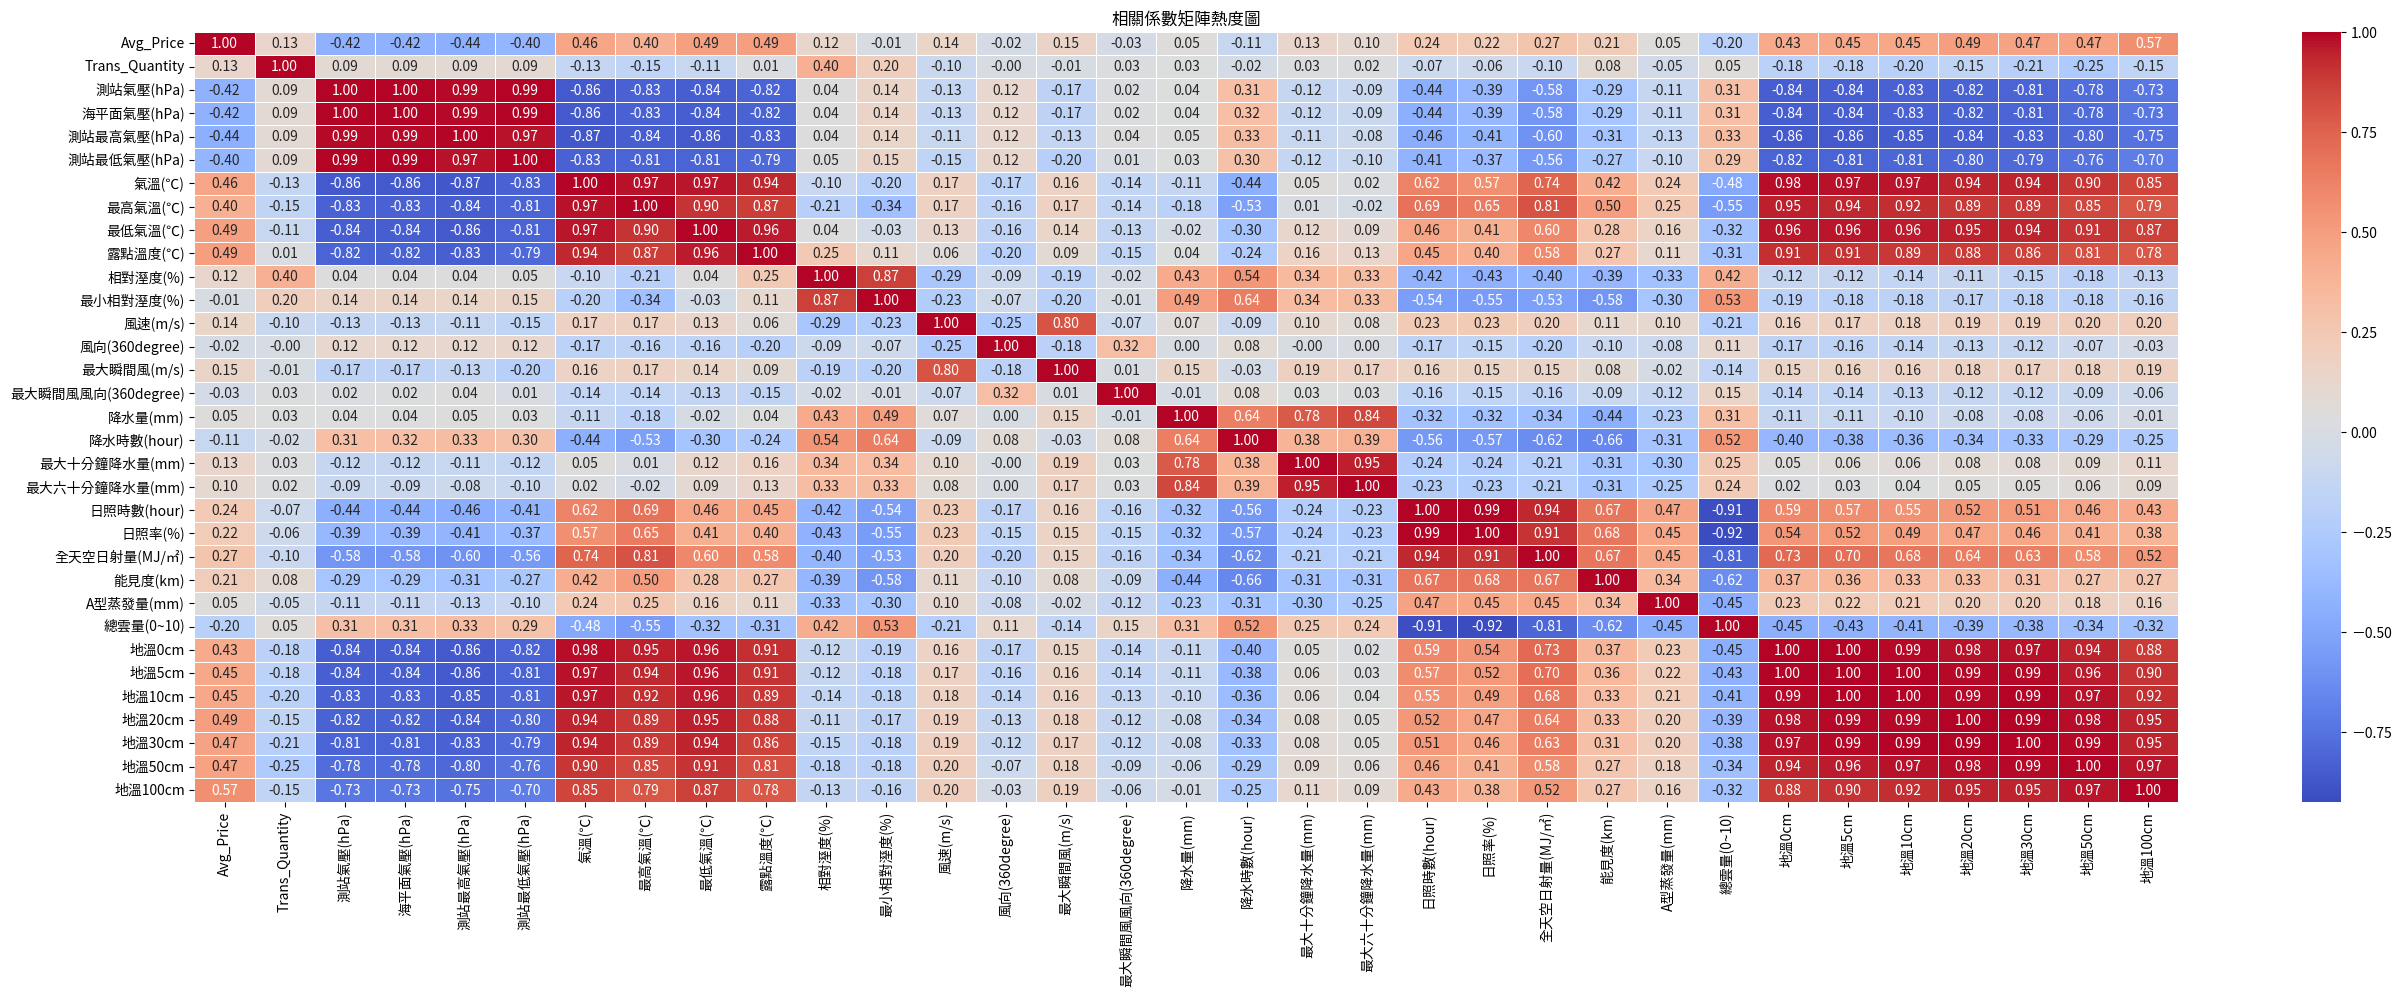

In [5]:
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定使用的中文字型
	
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

# 計算相關係數矩陣
correlation_matrix = yilan_df.corr()

# 使用 Seaborn 繪製熱度圖
plt.figure(figsize=(32, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# 設定圖表標題
plt.title("相關係數矩陣熱度圖")

# 顯示圖表
plt.show()

In [6]:
target_column = 'Avg_Price'

# 計算目標列與其他列的相關係數
correlations = yilan_df.corrwith(yilan_df[target_column])

# 找出相關係數絕對值在 0.3 之外的列
selected_columns = correlations[abs(correlations) > 0.2].index

# 篩選 DataFrame
filtered_df = yilan_df[selected_columns]

# 輸出篩選後的 DataFrame
filtered_df.head(20)

,Avg_Price,測站氣壓(hPa),海平面氣壓(hPa),測站最高氣壓(hPa),測站最低氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),露點溫度(℃),日照時數(hour),日照率(%),全天空日射量(MJ/㎡),能見度(km),地溫0cm,地溫5cm,地溫10cm,地溫20cm,地溫30cm,地溫50cm,地溫100cm
0,15.0,1020.5,1021.5,1022.9,1018.2,18.3,21.2,16.1,15.4,0.0,0.0,5.39,9.2,18.0,18.1,18.3,18.5,18.3,19.5,20.5
1,15.0,1019.3,1020.2,1021.1,1017.2,19.9,23.9,16.6,16.2,2.8,26.4,6.61,19.2,19.1,19.5,19.6,19.0,19.1,19.5,20.5
2,15.0,1015.8,1016.7,1018.8,1012.7,21.0,25.3,18.1,17.3,1.2,11.3,8.80,13.8,20.7,20.6,20.3,19.9,19.6,20.0,20.5
3,15.0,1016.4,1017.3,1019.3,1013.1,18.6,20.9,16.2,15.2,0.0,0.0,2.93,16.3,18.7,19.4,19.7,19.9,19.9,20.5,20.5
4,15.0,1017.3,1018.3,1019.6,1015.1,17.5,18.7,16.0,16.2,0.0,0.0,1.93,5.0,17.8,18.2,18.7,18.9,19.1,20.0,20.5
5,15.0,1022.0,1023.0,1025.3,1018.6,12.8,15.4,9.9,8.5,0.0,0.0,3.07,11.0,15.0,16.3,16.8,17.8,18.4,19.6,20.5
6,15.0,1025.6,1026.6,1027.6,1023.2,12.1,16.3,9.1,5.1,2.0,18.8,9.72,13.8,14.0,15.2,15.3,16.5,17.4,18.5,20.5
7,15.0,1027.3,1028.3,1030.2,1025.0,12.0,15.3,9.3,4.6,1.6,15.0,4.33,23.3,12.7,13.7,14.2,15.3,16.2,18.5,20.0
8,15.0,1029.4,1030.4,1030.9,1026.9,10.9,15.1,8.2,3.2,1.8,16.9,7.44,18.0,11.9,12.9,13.4,14.5,15.3,17.5,19.8
9,15.0,1028.0,1029.0,1030.2,1026.0,11.3,16.0,7.5,6.4,1.8,16.8,5.55,19.2,11.4,12.6,12.9,13.9,14.7,16.8,19.5


In [7]:
filtered_df1 = filtered_df.loc[:,['Avg_Price','露點溫度(℃)','全天空日射量(MJ/㎡)','地溫0cm','地溫20cm','能見度(km)']]
# filtered_df1 = filtered_df.loc[:,['Avg_Price','露點溫度(℃)','全天空日射量(MJ/㎡)','地溫0cm','地溫20cm']]

使用 2018-2021 當作訓練   2022 當作測試

In [8]:
first_2022_date = transiminsion_day[transiminsion_day.dt.year == 2022].idxmin()
print(f"the first index in 2022 {first_2022_date}")
first_2021_date = transiminsion_day[transiminsion_day.dt.year == 2021].idxmin()
print(f"the second index in 2021 {first_2021_date}")

the first index in 2022 908
the second index in 2021 678


In [9]:
train = filtered_df1.iloc[:908,:]
test = filtered_df1.iloc[908:,:]

print(train.shape)
print(test.shape)

(908, 6)
(282, 6)


In [10]:
target_column = 'Avg_Price'

# 選擇特徵和目標變數
X = train.drop(target_column, axis=1)  # 特徵
y = train[target_column]  # 目標變數

X_test = test.drop(target_column,axis=1)
y_test = test[target_column]

print(X.shape,y.shape,X_test.shape,y_test.shape)

(908, 5) (908,) (282, 5) (282,)


In [11]:
model = LinearRegression()

# 訓練模型
model.fit(X, y)

# 進行預測
y_pred = model.predict(X_test)

# 計算均方誤差
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # 使用 squared=False 得到 RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 71.71428130730287
Root Mean Squared Error (RMSE): 8.468428502815788
Mean Absolute Error (MAE): 6.666070086872785
R-squared (R2): 0.2808946670536079


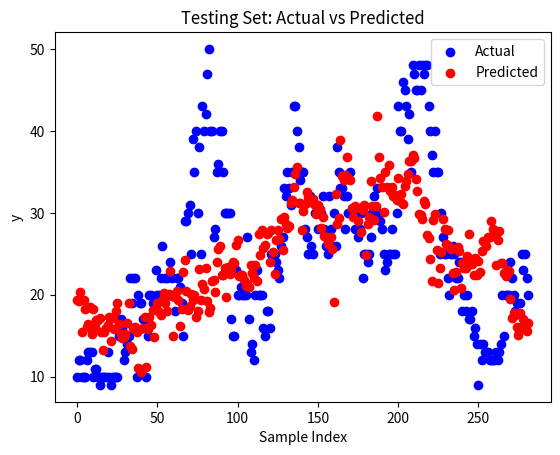

19.381985058417108
10.0
19.291249601009824
12.0
20.325381491549813
12.0
15.418189249055654
10.0
19.331702837310498
10.0
18.300753801113544
10.0
16.123854175614284
12.0
16.42719131043431
13.0
18.508788018034554
13.0
15.169046673934517
13.0
18.29414978962344
10.0
16.107653548188694
11.0
16.91403826222281
11.0
16.87390363453976
10.0
17.131551615630123
9.0
15.514378198524032
10.0
13.200436347153826
10.0
15.487949613044265
10.0
15.92186281891458
10.0
16.322964789041798
13.0
17.334069790113276
10.0
14.314633252264962
9.0
17.20134775147261
10.0
15.833238504508042
10.0
18.005645818598925
10.0
18.994217027123163
10.0
16.42949383495052
15.0
15.215088059685659
17.0
14.738645708130239
16.0
14.832903632709943
12.0
15.223583762150309
13.0
16.51159468296925
14.0
18.970259094801413
15.0
13.785594317761454
22.0
13.356290042197259
19.0
15.995619231209854
22.0
16.110236995253743
22.0
15.444813251143032
10.0
11.119047378038687
20.0
15.834419679987967
19.0
10.593572722789016
19.0
15.984684594761134
17.0
17

In [12]:
import matplotlib.pyplot as plt

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 可視化測試集的預測結果
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Testing Set: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.show()

for true_value, predicted_value in zip(y_test, y_pred):
    print(predicted_value)
    print(true_value)

## IQR remove outlier

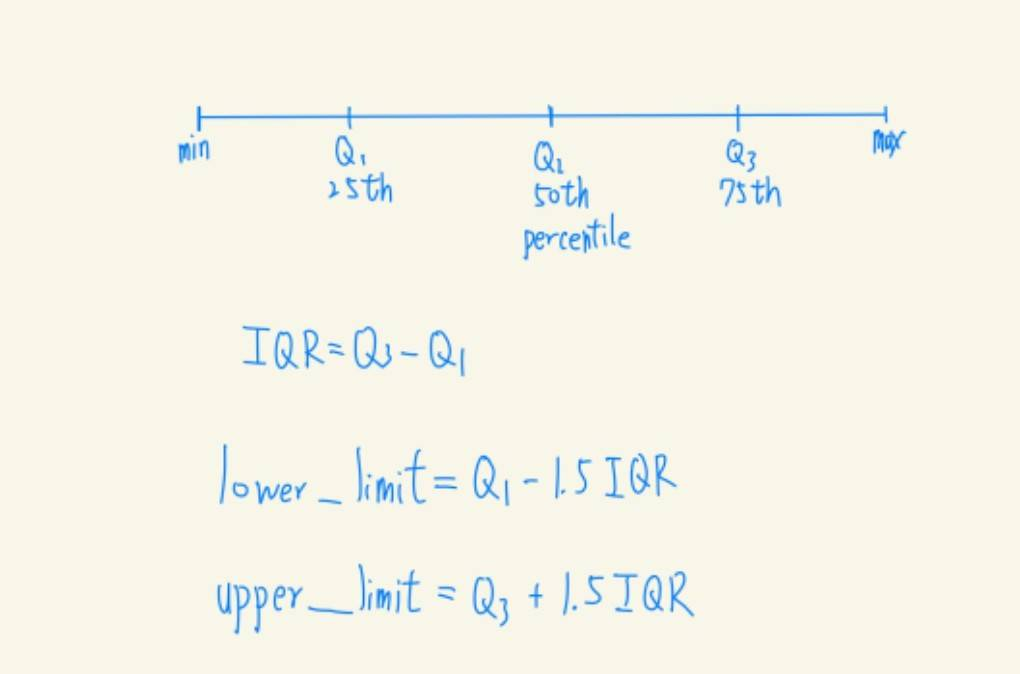

In [13]:
df_without_outlier = df.copy()
df_without_outlier['TransDate'] = df_without_outlier['TransDate'].astype(str)

def yearTranslate(row):
    date_str = row['TransDate']
    Cyear = date_str[0:3]
    Wyear = 1911 + int(Cyear)
    date_str = date_str.replace(Cyear, str(Wyear))
    return date_str

df_without_outlier['TransDate'] = df_without_outlier.apply(yearTranslate, axis = 1)
df_without_outlier['TransDate'] = df_without_outlier['TransDate'].apply(lambda x: x.replace('.', '-'))
df_without_outlier["TransDate"] = pd.to_datetime(df_without_outlier["TransDate"])

df_without_outlier.describe()

,TransDate,Avg_Price,Trans_Quantity,測站氣壓(hPa),海平面氣壓(hPa),測站最高氣壓(hPa),測站最低氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),...,能見度(km),A型蒸發量(mm),總雲量(0~10),地溫0cm,地溫5cm,地溫10cm,地溫20cm,地溫30cm,地溫50cm,地溫100cm
count,1190,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,...,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,2020-08-12 06:39:19.663865344,20.646218,4610.126050,1012.927479,1013.853866,1014.982941,1010.991933,23.450336,27.152101,20.650840,...,14.868571,0.534454,7.575210,23.905042,24.372941,24.627059,24.741513,24.559076,24.988403,25.189832
min,2018-01-02 00:00:00,5.000000,0.000000,991.100000,992.000000,993.900000,987.600000,10.300000,11.400000,7.000000,...,3.300000,-9.600000,0.000000,10.700000,11.700000,12.100000,13.000000,13.200000,14.700000,17.300000
25%,2019-05-09 06:00:00,10.000000,3880.000000,1008.000000,1008.900000,1009.700000,1006.400000,19.800000,22.925000,17.100000,...,10.300000,-1.600000,5.700000,20.000000,20.500000,20.700000,20.900000,20.800000,21.500000,22.000000
50%,2020-07-23 12:00:00,20.000000,4360.000000,1013.300000,1014.200000,1015.100000,1011.200000,23.600000,27.600000,21.100000,...,14.500000,-0.300000,8.500000,23.800000,24.300000,24.400000,24.400000,24.200000,24.600000,25.000000
75%,2021-12-13 12:00:00,28.750000,5600.000000,1017.800000,1018.700000,1020.200000,1015.800000,27.900000,32.175000,24.900000,...,19.000000,3.200000,10.000000,28.500000,28.975000,29.100000,29.175000,28.900000,29.000000,28.700000
max,2022-12-31 00:00:00,65.000000,8850.000000,1029.400000,1030.400000,1031.200000,1027.100000,31.400000,37.900000,28.000000,...,37.500000,8.000000,10.000000,33.900000,33.100000,33.000000,32.500000,32.100000,32.000000,31.200000
std,NaN,11.470665,1112.633954,6.607408,6.637307,6.730005,6.532351,4.707013,5.504494,4.428922,...,5.797192,3.195596,2.627268,4.715692,4.657148,4.700841,4.547315,4.526503,4.374160,3.679291


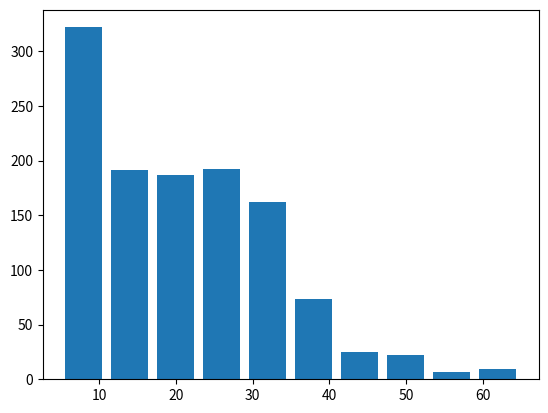

In [14]:
plt.hist(df.Avg_Price,rwidth=0.8)
plt.show()

In [15]:
q1 = df_without_outlier.Avg_Price.quantile(0.25)
q3 = df_without_outlier.Avg_Price.quantile(0.75)

IQR = q3 - q1
IQR

18.75

In [16]:
lower_limit = q1-1.5*IQR
upper_limit = q3+1.5*IQR
lower_limit,upper_limit

(-18.125, 56.875)

In [17]:
df_without_outlier[(df_without_outlier.Avg_Price<lower_limit) | (df_without_outlier.Avg_Price>upper_limit)].shape
print(df_without_outlier[(df_without_outlier.Avg_Price<lower_limit) | (df_without_outlier.Avg_Price>upper_limit)])

     TransDate  Avg_Price  Trans_Quantity  測站氣壓(hPa)  海平面氣壓(hPa)  測站最高氣壓(hPa)  \
781 2021-07-22       58.0          5000.0      995.5       996.4        998.7   
805 2021-08-20       60.0          4580.0     1009.5      1010.4       1010.5   
807 2021-08-22       60.0          4200.0     1006.8      1007.7       1008.1   
813 2021-08-31       60.0          4200.0     1011.3      1012.2       1012.7   
814 2021-09-01       59.0          4200.0     1010.3      1011.2       1011.6   
815 2021-09-03       62.0          4650.0     1007.5      1008.4       1008.5   
817 2021-09-05       60.0          4200.0     1009.6      1010.5       1011.6   
818 2021-09-07       65.0          4300.0     1010.2      1011.1       1012.0   
819 2021-09-08       60.0          3800.0     1009.5      1010.4       1010.7   
820 2021-09-09       63.0          3000.0     1009.8      1010.7       1011.1   

     測站最低氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  ...  能見度(km)  A型蒸發量(mm)  總雲量(0~10)  \
781        993.8   27.2    

In [18]:
print(df_without_outlier.shape)
df_no_outlier = df_without_outlier[(df_without_outlier.Avg_Price>lower_limit) & (df_without_outlier.Avg_Price<upper_limit)]
print(df_no_outlier.shape)

(1190, 34)
(1180, 34)


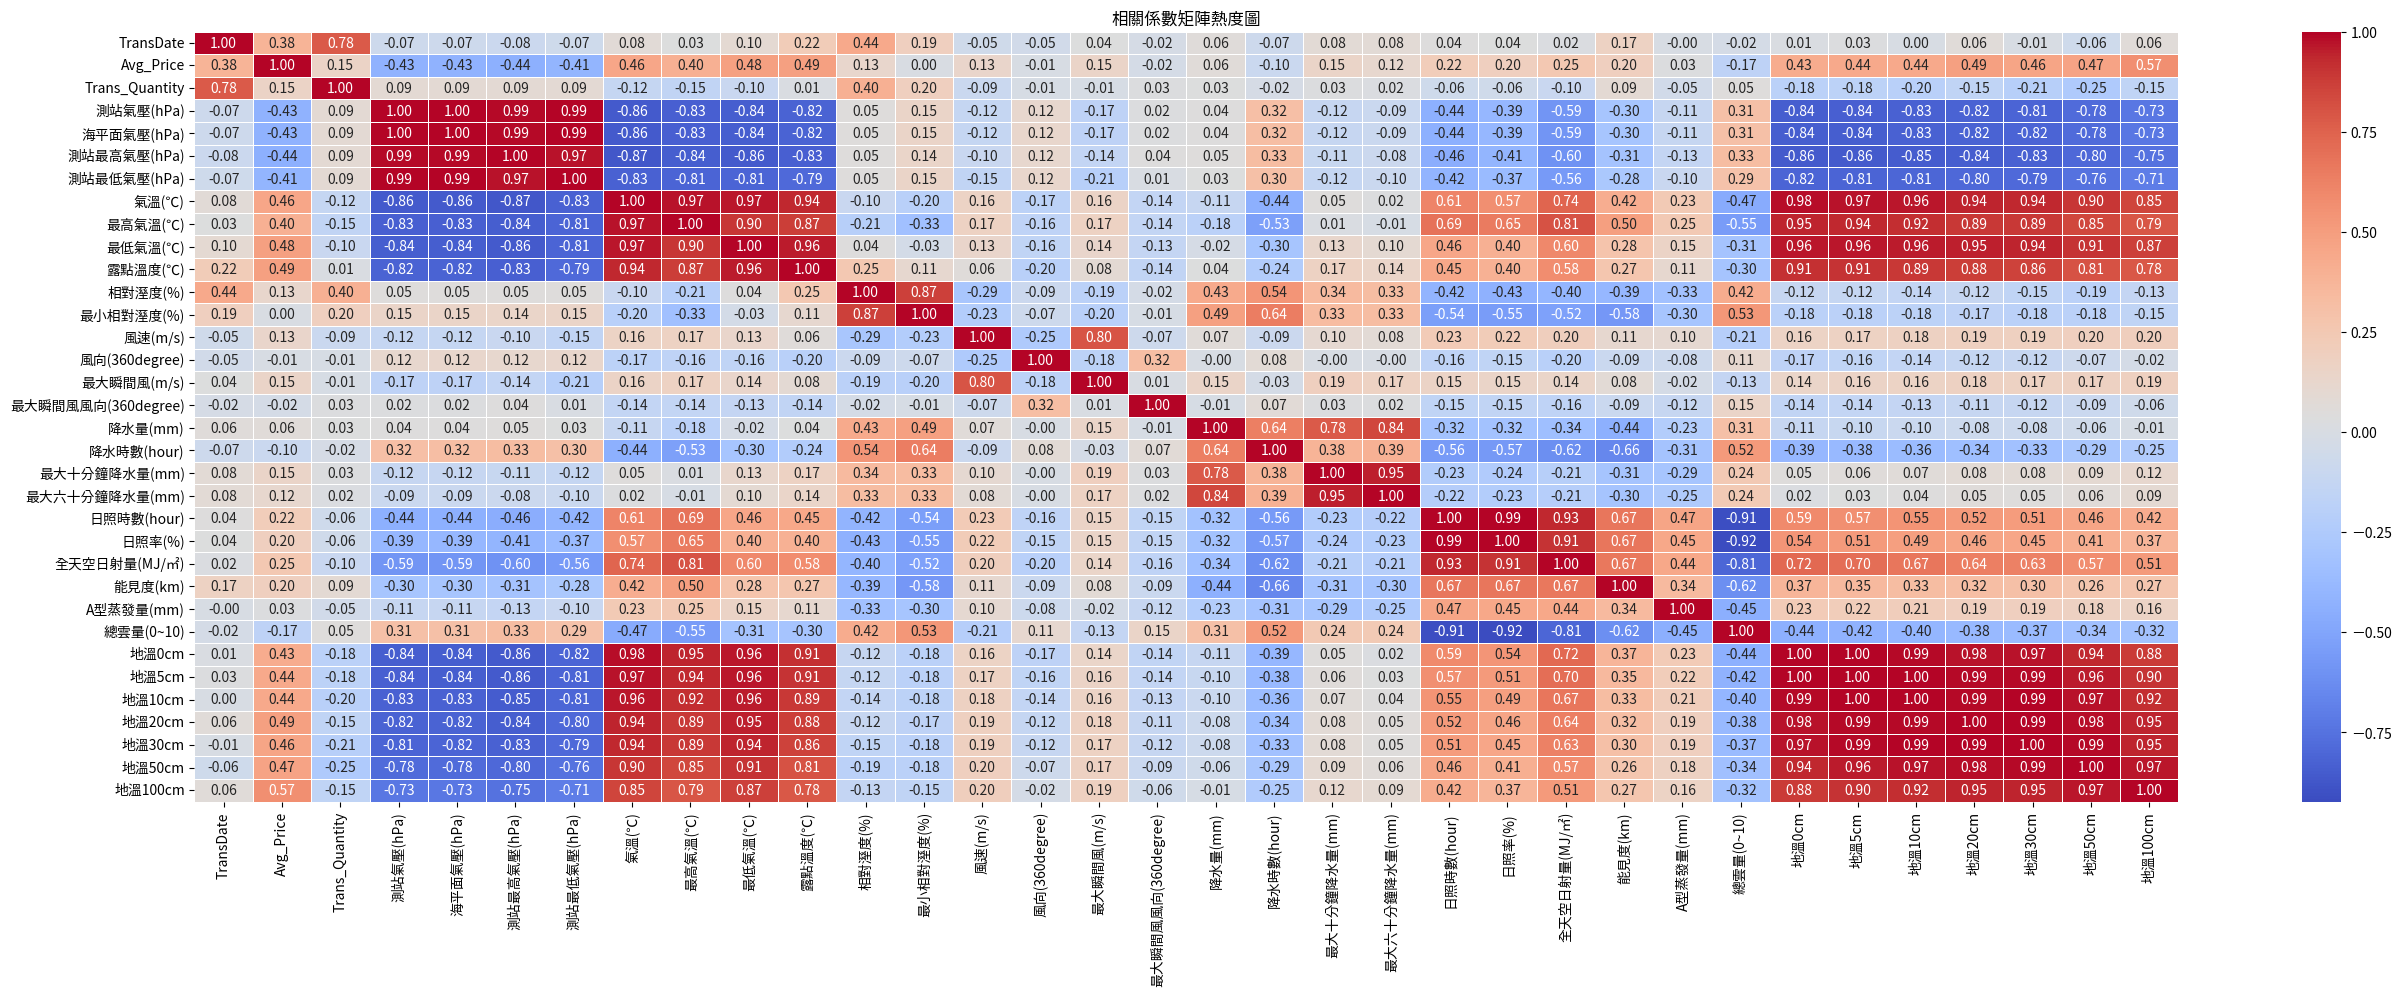

In [19]:
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定使用的中文字型
	
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

# 計算相關係數矩陣
correlation_matrix = df_no_outlier.corr()

# 使用 Seaborn 繪製熱度圖
plt.figure(figsize=(32, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# 設定圖表標題
plt.title("相關係數矩陣熱度圖")

# 顯示圖表
plt.show()

In [20]:
transiminsion_day = df_no_outlier['TransDate']
df_no_outlier.drop(labels=['TransDate'],axis='columns',inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_1728\2751528599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outlier.drop(labels=['TransDate'],axis='columns',inplace=True)


In [21]:
target_column = 'Avg_Price'

# 計算目標列與其他列的相關係數
correlations = df_no_outlier.corrwith(df_no_outlier[target_column])

# 找出相關係數絕對值在 0.3 之外的列
selected_columns = correlations[abs(correlations) > 0.19].index

# 篩選 DataFrame
filtered_df = df_no_outlier[selected_columns]

# 輸出篩選後的 DataFrame
filtered_df.head(20)

,Avg_Price,測站氣壓(hPa),海平面氣壓(hPa),測站最高氣壓(hPa),測站最低氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),露點溫度(℃),日照時數(hour),日照率(%),全天空日射量(MJ/㎡),能見度(km),地溫0cm,地溫5cm,地溫10cm,地溫20cm,地溫30cm,地溫50cm,地溫100cm
0,15.0,1020.5,1021.5,1022.9,1018.2,18.3,21.2,16.1,15.4,0.0,0.0,5.39,9.2,18.0,18.1,18.3,18.5,18.3,19.5,20.5
1,15.0,1019.3,1020.2,1021.1,1017.2,19.9,23.9,16.6,16.2,2.8,26.4,6.61,19.2,19.1,19.5,19.6,19.0,19.1,19.5,20.5
2,15.0,1015.8,1016.7,1018.8,1012.7,21.0,25.3,18.1,17.3,1.2,11.3,8.80,13.8,20.7,20.6,20.3,19.9,19.6,20.0,20.5
3,15.0,1016.4,1017.3,1019.3,1013.1,18.6,20.9,16.2,15.2,0.0,0.0,2.93,16.3,18.7,19.4,19.7,19.9,19.9,20.5,20.5
4,15.0,1017.3,1018.3,1019.6,1015.1,17.5,18.7,16.0,16.2,0.0,0.0,1.93,5.0,17.8,18.2,18.7,18.9,19.1,20.0,20.5
5,15.0,1022.0,1023.0,1025.3,1018.6,12.8,15.4,9.9,8.5,0.0,0.0,3.07,11.0,15.0,16.3,16.8,17.8,18.4,19.6,20.5
6,15.0,1025.6,1026.6,1027.6,1023.2,12.1,16.3,9.1,5.1,2.0,18.8,9.72,13.8,14.0,15.2,15.3,16.5,17.4,18.5,20.5
7,15.0,1027.3,1028.3,1030.2,1025.0,12.0,15.3,9.3,4.6,1.6,15.0,4.33,23.3,12.7,13.7,14.2,15.3,16.2,18.5,20.0
8,15.0,1029.4,1030.4,1030.9,1026.9,10.9,15.1,8.2,3.2,1.8,16.9,7.44,18.0,11.9,12.9,13.4,14.5,15.3,17.5,19.8
9,15.0,1028.0,1029.0,1030.2,1026.0,11.3,16.0,7.5,6.4,1.8,16.8,5.55,19.2,11.4,12.6,12.9,13.9,14.7,16.8,19.5


In [22]:
filtered_df1 = filtered_df.loc[:,['Avg_Price','露點溫度(℃)','全天空日射量(MJ/㎡)','地溫0cm','地溫20cm','能見度(km)']]

In [23]:
first_2022_date = transiminsion_day[transiminsion_day.dt.year == 2022].idxmin()
print(f"the first index in 2022 {first_2022_date}")
first_2021_date = transiminsion_day[transiminsion_day.dt.year == 2021].idxmin()
print(f"the second index in 2021 {first_2021_date}")

the first index in 2022 908
the second index in 2021 678


In [24]:
train = filtered_df1.iloc[:908,:]
test = filtered_df1.iloc[908:,:]

print(train.shape)
print(test.shape)

(908, 6)
(272, 6)


In [25]:
target_column = 'Avg_Price'

# 選擇特徵和目標變數
X = train.drop(target_column, axis=1)  # 特徵
y = train[target_column]  # 目標變數

X_test = test.drop(target_column,axis=1)
y_test = test[target_column]

model = LinearRegression()

# 訓練模型
model.fit(X, y)

# 進行預測
y_pred = model.predict(X_test)

# 計算均方誤差
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # 使用 squared=False 得到 RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 74.9600851924613
Root Mean Squared Error (RMSE): 8.657949248665142
Mean Absolute Error (MAE): 6.666751119852541
R-squared (R2): 0.22384078935875973


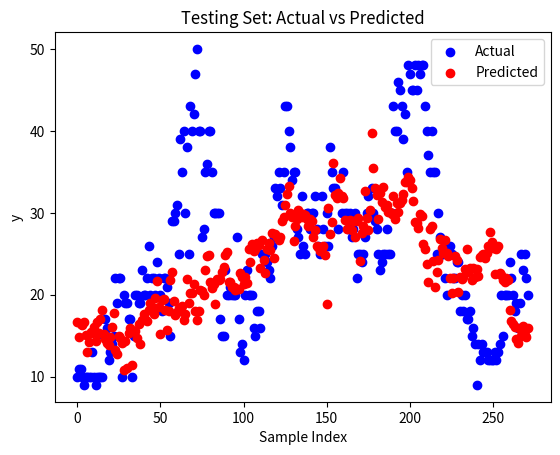

16.734673004654518
10.0
14.899924978384057
11.0
16.396492246946103
11.0
16.34109612189283
10.0
16.62678225752622
9.0
15.138832169354725
10.0
13.017048613478845
10.0
14.247655061207887
10.0
15.413030134832201
10.0
15.290623083204007
13.0
16.093304518876558
10.0
14.334436041167997
9.0
16.69504616415075
10.0
15.304140644672767
10.0
17.067245544730724
10.0
18.087070598859604
10.0
15.204842219669402
15.0
14.548166145022794
17.0
14.158129442562885
16.0
13.815019712628477
12.0
14.888144745855222
13.0
16.037168030510305
14.0
17.742405171434612
15.0
13.269355531727609
22.0
12.829615884732217
19.0
14.938872077772
22.0
14.766008256074727
22.0
14.060657035108967
10.0
10.87256857907844
20.0
14.306439888089457
19.0
11.01179783626694
19.0
15.342030783604443
17.0
15.991382668385391
17.0
11.482245028571562
10.0
15.527029753875201
15.0
15.606525244749086
20.0
14.754698941466863
20.0
16.465464508662556
19.0
13.949177639936728
19.0
16.873436286435968
23.0
17.714125877123095
20.0
17.067067004264857
20.0
16

In [26]:
import matplotlib.pyplot as plt

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 可視化測試集的預測結果
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Testing Set: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.show()

for true_value, predicted_value in zip(y_test, y_pred):
    print(predicted_value)
    print(true_value)

## LOF（Local Outlier Factor）

他是以種基於密度來檢測異常值的方法，LOF的基本思想是，異常值通常在數據分布中具有較低的局部密度。因此，LOF通過比較每個數據點與其鄰近區域內其他數據點的密度來評估每個數據點的異常性。如果一個數據點的局部密度較低，而其鄰近區域的其他點的局部密度較高，則該數據點可能被視為異常值。

In [27]:
from sklearn.neighbors import LocalOutlierFactor

In [28]:
yilan_df = df.copy()
yilan_df['TransDate'] = yilan_df['TransDate'].astype(str)

def yearTranslate(row):
    date_str = row['TransDate']
    Cyear = date_str[0:3]
    Wyear = 1911 + int(Cyear)
    date_str = date_str.replace(Cyear, str(Wyear))
    return date_str

yilan_df['TransDate'] = yilan_df.apply(yearTranslate, axis = 1)
yilan_df['TransDate'] = yilan_df['TransDate'].apply(lambda x: x.replace('.', '-'))
yilan_df["TransDate"] = pd.to_datetime(yilan_df["TransDate"])

transiminsion_day = yilan_df['TransDate']
yilan_df.drop(labels=['TransDate'],axis='columns',inplace=True)

In [29]:
features = yilan_df.columns

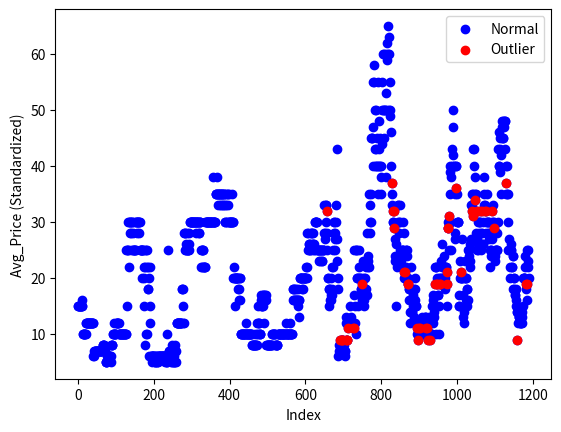

In [30]:
# 訓練 LOF 模型
lof = LocalOutlierFactor(contamination=0.05)  # contamination 用於指定異常值的比例 表示預期數據中有5%的樣本是異常值
outliers = lof.fit_predict(yilan_df[['Avg_Price']]) #方法將計算每個數據點的 LOF 分數，並返回一個陣列，該陣列中的每個元素表示對應數據點的異常值預測。

# 將異常值的索引標記為 True
outliers = outliers == -1

# 繪製結果
plt.scatter(yilan_df.index, yilan_df['Avg_Price'], color='blue', label='Normal')
plt.scatter(yilan_df.index[outliers], yilan_df['Avg_Price'][outliers], color='red', label='Outlier')
plt.xlabel('Index')
plt.ylabel('Avg_Price (Standardized)')
plt.legend()
plt.show()

In [31]:
yilan_df['outlier'] = outliers
yilan_df.head(4)

,Avg_Price,Trans_Quantity,測站氣壓(hPa),海平面氣壓(hPa),測站最高氣壓(hPa),測站最低氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),露點溫度(℃),...,A型蒸發量(mm),總雲量(0~10),地溫0cm,地溫5cm,地溫10cm,地溫20cm,地溫30cm,地溫50cm,地溫100cm,outlier
0,15.0,1760.0,1020.5,1021.5,1022.9,1018.2,18.3,21.2,16.1,15.4,...,-0.6,10.0,18.0,18.1,18.3,18.5,18.3,19.5,20.5,False
1,15.0,1850.0,1019.3,1020.2,1021.1,1017.2,19.9,23.9,16.6,16.2,...,-1.4,8.8,19.1,19.5,19.6,19.0,19.1,19.5,20.5,False
2,15.0,1760.0,1015.8,1016.7,1018.8,1012.7,21.0,25.3,18.1,17.3,...,-1.7,9.0,20.7,20.6,20.3,19.9,19.6,20.0,20.5,False
3,15.0,1850.0,1016.4,1017.3,1019.3,1013.1,18.6,20.9,16.2,15.2,...,-0.2,9.8,18.7,19.4,19.7,19.9,19.9,20.5,20.5,False


In [32]:
df_no_outlier = yilan_df[yilan_df.outlier==False]
df_no_outlier.shape

(1135, 34)

In [33]:
target_column = 'Avg_Price'

# 計算目標列與其他列的相關係數
correlations = df_no_outlier.corrwith(df_no_outlier[target_column])

# 找出相關係數絕對值在 0.3 之外的列
selected_columns = correlations[abs(correlations) > 0.19].index

# 篩選 DataFrame
filtered_df = df_no_outlier[selected_columns]

# 輸出篩選後的 DataFrame
filtered_df.head(20)

,Avg_Price,測站氣壓(hPa),海平面氣壓(hPa),測站最高氣壓(hPa),測站最低氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),露點溫度(℃),日照時數(hour),...,全天空日射量(MJ/㎡),能見度(km),總雲量(0~10),地溫0cm,地溫5cm,地溫10cm,地溫20cm,地溫30cm,地溫50cm,地溫100cm
0,15.0,1020.5,1021.5,1022.9,1018.2,18.3,21.2,16.1,15.4,0.0,...,5.39,9.2,10.0,18.0,18.1,18.3,18.5,18.3,19.5,20.5
1,15.0,1019.3,1020.2,1021.1,1017.2,19.9,23.9,16.6,16.2,2.8,...,6.61,19.2,8.8,19.1,19.5,19.6,19.0,19.1,19.5,20.5
2,15.0,1015.8,1016.7,1018.8,1012.7,21.0,25.3,18.1,17.3,1.2,...,8.80,13.8,9.0,20.7,20.6,20.3,19.9,19.6,20.0,20.5
3,15.0,1016.4,1017.3,1019.3,1013.1,18.6,20.9,16.2,15.2,0.0,...,2.93,16.3,9.8,18.7,19.4,19.7,19.9,19.9,20.5,20.5
4,15.0,1017.3,1018.3,1019.6,1015.1,17.5,18.7,16.0,16.2,0.0,...,1.93,5.0,10.0,17.8,18.2,18.7,18.9,19.1,20.0,20.5
5,15.0,1022.0,1023.0,1025.3,1018.6,12.8,15.4,9.9,8.5,0.0,...,3.07,11.0,10.0,15.0,16.3,16.8,17.8,18.4,19.6,20.5
6,15.0,1025.6,1026.6,1027.6,1023.2,12.1,16.3,9.1,5.1,2.0,...,9.72,13.8,6.7,14.0,15.2,15.3,16.5,17.4,18.5,20.5
7,15.0,1027.3,1028.3,1030.2,1025.0,12.0,15.3,9.3,4.6,1.6,...,4.33,23.3,7.2,12.7,13.7,14.2,15.3,16.2,18.5,20.0
8,15.0,1029.4,1030.4,1030.9,1026.9,10.9,15.1,8.2,3.2,1.8,...,7.44,18.0,7.5,11.9,12.9,13.4,14.5,15.3,17.5,19.8
9,15.0,1028.0,1029.0,1030.2,1026.0,11.3,16.0,7.5,6.4,1.8,...,5.55,19.2,7.2,11.4,12.6,12.9,13.9,14.7,16.8,19.5


In [34]:
filtered_df1 = filtered_df.loc[:,['Avg_Price','露點溫度(℃)','全天空日射量(MJ/㎡)','地溫0cm','地溫20cm','能見度(km)']]

In [35]:
first_2022_date = transiminsion_day[transiminsion_day.dt.year == 2022].idxmin()
print(f"the first index in 2022 {first_2022_date}")
first_2021_date = transiminsion_day[transiminsion_day.dt.year == 2021].idxmin()
print(f"the second index in 2021 {first_2021_date}")

the first index in 2022 908
the second index in 2021 678


In [36]:
train = filtered_df1.iloc[:908,:]
test = filtered_df1.iloc[908:,:]

print(train.shape)
print(test.shape)

(908, 6)
(227, 6)


In [37]:
target_column = 'Avg_Price'

# 選擇特徵和目標變數
X = train.drop(target_column, axis=1)  # 特徵
y = train[target_column]  # 目標變數

X_test = test.drop(target_column,axis=1)
y_test = test[target_column]

model = LinearRegression()

# 訓練模型
model.fit(X, y)

# 進行預測
y_pred = model.predict(X_test)

# 計算均方誤差
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # 使用 squared=False 得到 RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 79.79658479023345
Root Mean Squared Error (RMSE): 8.932893416482335
Mean Absolute Error (MAE): 6.970530426376266
R-squared (R2): 0.1253339756760231


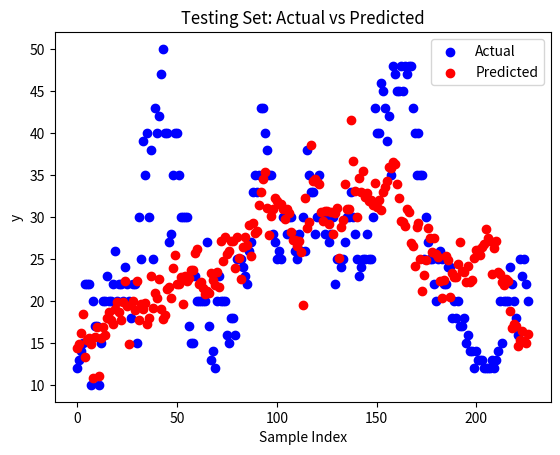

14.40929440601139
12.0
14.90659911529987
13.0
16.159004101013636
14.0
18.481269930953943
15.0
13.29979094942209
22.0
15.399805788296277
22.0
15.532714317983341
22.0
14.923665264197535
10.0
10.767644991661246
20.0
15.694673167300472
17.0
16.867543325524917
17.0
11.01010920946906
10.0
15.534442444343558
15.0
16.85550438594265
20.0
15.888221362249688
20.0
17.92917246327463
23.0
18.66626900962871
20.0
17.708757702103192
20.0
17.283073006222217
22.0
19.01757401211856
26.0
19.918063330996432
20.0
18.728763412483357
22.0
17.762224392225097
22.0
19.858686080486034
20.0
22.40187006522639
24.0
19.447662653102153
22.0
14.904315444688727
20.0
19.539262667853848
18.0
19.996096681850876
22.0
18.91475993931147
22.0
22.344899479997476
15.0
17.77664048866716
30.0
19.65887154180723
25.0
19.020435026898827
39.0
19.75796014776194
35.0
17.209675446362603
40.0
17.9356061156838
30.0
22.94073698064011
38.0
19.148592103983344
25.0
20.8928841500689
43.0
20.40516343070278
40.0
22.657410998670297
42.0
19.02319428

In [38]:
import matplotlib.pyplot as plt

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 可視化測試集的預測結果
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Testing Set: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.show()

for true_value, predicted_value in zip(y_test, y_pred):
    print(predicted_value)
    print(true_value)

# 使用對 outlier 沒有影響的模型

## ransac

In [39]:
yilan_df = df.copy()
yilan_df['TransDate'] = yilan_df['TransDate'].astype(str)

def yearTranslate(row):
    date_str = row['TransDate']
    Cyear = date_str[0:3]
    Wyear = 1911 + int(Cyear)
    date_str = date_str.replace(Cyear, str(Wyear))
    return date_str

yilan_df['TransDate'] = yilan_df.apply(yearTranslate, axis = 1)
yilan_df['TransDate'] = yilan_df['TransDate'].apply(lambda x: x.replace('.', '-'))
yilan_df["TransDate"] = pd.to_datetime(yilan_df["TransDate"])

transiminsion_day = yilan_df['TransDate']
yilan_df.drop(labels=['TransDate'],axis='columns',inplace=True)

target_column = 'Avg_Price'

# 計算目標列與其他列的相關係數
correlations = yilan_df.corrwith(yilan_df[target_column])

# 找出相關係數絕對值在 0.3 之外的列
selected_columns = correlations[abs(correlations) > 0.2].index

# 篩選 DataFrame
filtered_df = yilan_df[selected_columns]

filtered_df1 = filtered_df.loc[:,['Avg_Price','露點溫度(℃)','全天空日射量(MJ/㎡)','地溫0cm','地溫20cm','能見度(km)']]
# filtered_df1 = filtered_df.loc[:,['Avg_Price','露點溫度(℃)','全天空日射量(MJ/㎡)','地溫0cm','地溫20cm']]

train = filtered_df1.iloc[:908,:]
test = filtered_df1.iloc[908:,:]

target_column = 'Avg_Price'

# 選擇特徵和目標變數
X = train.drop(target_column, axis=1)  # 特徵
y = train[target_column]  # 目標變數

X_test = test.drop(target_column,axis=1)
y_test = test[target_column]

In [40]:
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression

ransac = RANSACRegressor(random_state=42,residual_threshold=9)

# 擬合模型
ransac.fit(X, y)

# 取得內點和外點的索引
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# 進行預測
y_pred = ransac.predict(X_test)

# 計算均方誤差
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # 使用 squared=False 得到 RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 81.92798840665776
Root Mean Squared Error (RMSE): 9.051408089720503
Mean Absolute Error (MAE): 6.893485590827775
R-squared (R2): 0.17847808962427247


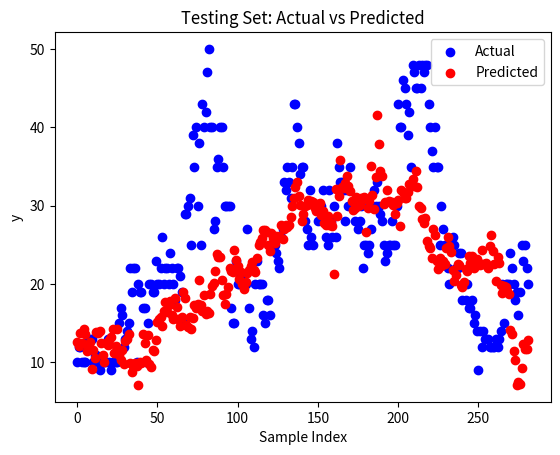

12.561085442252125
10.0
12.105507993881861
12.0
13.732358019226748
12.0
12.50299939698223
10.0
14.216581047477263
10.0
13.593383333009495
10.0
11.417553876824165
12.0
12.108655641123384
13.0
12.598264482437155
13.0
9.174036249986745
13.0
11.565929936456712
10.0
10.541642517697458
11.0
13.837518192307364
11.0
13.797867620083377
10.0
13.997173777501647
9.0
12.531178155979337
10.0
10.964941511664268
10.0
10.045083213441206
10.0
12.453001750660171
10.0
12.194121473766469
13.0
12.884643862089977
10.0
13.230286692190553
9.0
14.279999167798273
10.0
11.24886038984847
10.0
12.060423541212486
10.0
14.241618186013227
10.0
10.89671775198724
15.0
10.294906785030406
17.0
11.610848567795045
16.0
9.799058072863335
12.0
12.76731292904702
13.0
13.025566153041439
14.0
13.685675080936758
15.0
9.88545217723939
22.0
8.755383584021864
19.0
9.495750580959193
22.0
9.890052665870975
22.0
9.513928853609219
10.0
7.139740550534299
20.0
10.056762565372775
19.0
9.944041993560884
19.0
13.688779488200254
17.0
12.49268

In [41]:
import matplotlib.pyplot as plt

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 可視化測試集的預測結果
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Testing Set: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.show()

for true_value, predicted_value in zip(y_test, y_pred):
    print(predicted_value)
    print(true_value)

## HuberRegressor

In [42]:
from sklearn.linear_model import HuberRegressor

In [43]:
# 初始化 Huber 回歸器
huber = HuberRegressor(epsilon=6)  # epsilon 是 Huber 損失的閾值 1.35

# 擬合模型
huber.fit(X, y)
# 進行預測
y_pred = huber.predict(X_test)

# 計算均方誤差
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # 使用 squared=False 得到 RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 71.7142721893843
Root Mean Squared Error (RMSE): 8.46842796446804
Mean Absolute Error (MAE): 6.666065880906354
R-squared (R2): 0.2808947584823128


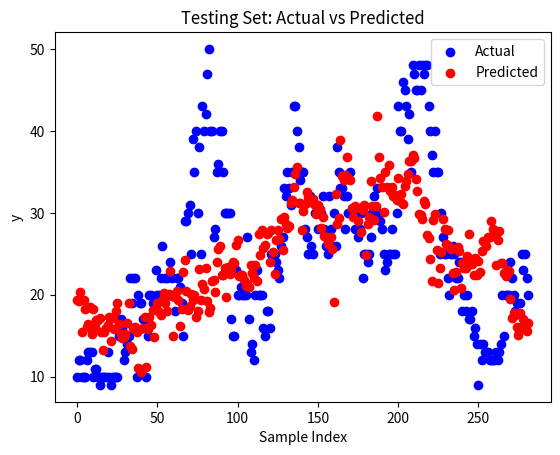

19.38197310335102
10.0
19.291261919279965
12.0
20.32538355916439
12.0
15.418202581186652
10.0
19.331697829542634
10.0
18.30074504162374
10.0
16.123862420632978
12.0
16.42719172868453
13.0
18.508770911158738
13.0
15.169048368032264
13.0
18.29411620921872
10.0
16.1076435689055
11.0
16.914024334438164
11.0
16.873886553242514
10.0
17.131534978508306
9.0
15.514374371009382
10.0
13.200446188033744
10.0
15.487960160718163
10.0
15.921875890041598
10.0
16.322954779356163
13.0
17.33405235899764
10.0
14.314646496520165
9.0
17.20134747811452
10.0
15.833255901826487
10.0
18.00564664003894
10.0
18.994185647784345
10.0
16.42946817435629
15.0
15.215096186444267
17.0
14.738648460741096
16.0
14.832922202517967
12.0
15.22359175349381
13.0
16.51159296835491
14.0
18.97022863663203
15.0
13.785581903159567
22.0
13.356291172541624
19.0
15.995611354936695
22.0
16.110207516159736
22.0
15.444790492724138
10.0
11.119086377847552
20.0
15.834405787346864
19.0
10.593613172277927
19.0
15.984661293158322
17.0
17.30026

In [44]:
import matplotlib.pyplot as plt

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 可視化測試集的預測結果
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Testing Set: Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('y')
plt.legend()
plt.show()

for true_value, predicted_value in zip(y_test, y_pred):
    print(predicted_value)
    print(true_value)